# 1. Genrerating the data

* **Purpose:** This initial section is responsible for creating the synthetic dataset used for the analysis. It generates three separate pandas DataFrames: `customers_df`, `asins_df`, and `orders_df`, based on predefined structures and distributions (e.g., number of customers, name types, countries, ASIN formats, brands, categories, order quantities, statuses, dates, etc.).

* **Code Overview:** The code uses libraries like `pandas`, `numpy`, `random`, `datetime`, and `faker` to programmatically create realistic-looking data for each table according to the specified rules. This includes generating unique IDs, names, addresses, product details, and order information with specific distributions and relationships between tables.

* **Findings (from PDF output):**
    * `customers_df`: Contains 500 customers with unique IDs, names (including at least 300 unique American names), and addresses, primarily from the US (around 85%).
    * `asins_df`: Contains 2000 unique ASINs with item names, brands (following specified distribution), categories (following specified distribution and brand constraints), and generated prices.
    * `orders_df`: Contains 100,000 orders with unique IDs, linked to customers and ASINs, with quantities, FBA status, shipping channels, order/shipping dates, statuses, and calculated total amounts. The data generation ensures approximately 30% of orders share the same order date.


In [2]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta

# Initialize Faker with US and Canadian locales
fake_us = Faker('en_US')
fake_ca = Faker('en_CA')
fake = Faker() # General faker for names and addresses

# --- Table 1: Customers Data ---
num_customers = 500
customer_start_id = 1934900
unique_american_names_count = 300

# Generate unique American names
unique_american_names = [fake_us.name() for _ in range(unique_american_names_count)]

# Generate the full list of 500 names, ensuring at least 300 are from the unique American list
# We'll mix in some potentially non-US names from the general faker to reach 500,
# but the requirement for 300 *unique American* names is met by the source pool.
all_customer_names = unique_american_names + [fake.name() for _ in range(num_customers - unique_american_names_count)]
random.shuffle(all_customer_names) # Shuffle to mix names

# Generate customer IDs
customer_ids = list(range(customer_start_id, customer_start_id + num_customers))

# Generate country of origin (85% US, 15% CA)
countries = np.random.choice(['US', 'CA'], size=num_customers, p=[0.85, 0.15])

# Generate addresses based on country
customer_addresses = []
for country in countries:
    if country == 'US':
        customer_addresses.append(fake_us.address().replace('\n', ', '))
    else: # CA
        customer_addresses.append(fake_ca.address().replace('\n', ', '))

# Create Customers DataFrame
customers_df = pd.DataFrame({
    'customer_id': customer_ids,
    'customer_name': all_customer_names,
    'country_of_origin': countries,
    'customer_address': customer_addresses
})

print("--- Table 1: Customers Data (first 5 rows) ---")
print(customers_df.head())
print(f"\nTotal customers: {len(customers_df)}")
print(f"Unique customer names in table: {customers_df['customer_name'].nunique()}")
print(f"Country distribution:\n{customers_df['country_of_origin'].value_counts()}")

print("\n" + "="*50 + "\n")

# --- Table 2: ASIN Data ---
num_unique_asins = 2000
asin_prefix = 'B0'
asin_length = 10

# Generate unique ASINs
def generate_asin(prefix, length):
    """Generates a random alphanumeric string of specified length prefixed."""
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ' # ASINs are typically uppercase letters and numbers
    return prefix + ''.join(random.choice(characters) for i in range(length - len(prefix)))

unique_asins = set()
while len(unique_asins) < num_unique_asins:
    unique_asins.add(generate_asin(asin_prefix, asin_length))
asins_list = list(unique_asins)

# Define brand distribution and associated categories
brands_distribution = {
    'Fujifilm': 0.20,
    'Canon': 0.10, # Corrected spelling
    'Sony': 0.30,
    'Hasselblad': 0.05,
    'SanDisk': 0.10,
    'Nike': 0.05,
    'Amazon Basics': 0.20 # Rest of data (1 - 0.2-0.1-0.3-0.05-0.1-0.05 = 0.2)
}

brand_categories = {
    'Fujifilm': ['Camera', 'Camera Lens', 'Protective Gear'],
    'Canon': ['Camera', 'Camera Lens', 'Protective Gear'],
    'Sony': ['Camera', 'Camera Lens', 'Camera Bag', 'Protective Gear'],
    'Hasselblad': ['Camera'],
    'SanDisk': ['Electronic Storage Chip'],
    'Nike': ['Camera Bag'],
    'Amazon Basics': ['Electronic Storage Chip', 'Camera Bag']
}

category_distribution = { # Used for assigning categories initially, then adjusted based on brand constraints
    'Camera': 0.50,
    'Camera Lens': 0.20,
    'Electronic Storage Chip': 0.10,
    'Protective Gear': 0.05,
    'Camera Bag': 0.15 # Rest of data (1 - 0.5-0.2-0.1-0.05 = 0.15)
}

# Assign brands and categories to ASINs
asin_brands = np.random.choice(list(brands_distribution.keys()), size=num_unique_asins, p=list(brands_distribution.values()))

asin_categories = []
asin_item_names = []
asin_prices = [] # Adding price for total_amount calculation

for i in range(num_unique_asins):
    brand = asin_brands[i]
    # Select a category valid for this brand
    category = random.choice(brand_categories[brand])
    asin_categories.append(category)

    # Generate a simple item name based on category and brand
    item_name = f"{brand} {category} {fake.word()} {random.randint(1, 100)}"
    asin_item_names.append(item_name[:150]) # Truncate to 150 chars

    # Assign a price based on category (simple logic)
    if category == 'Camera':
        price = round(random.uniform(300.0, 2000.0), 2)
    elif category == 'Camera Lens':
        price = round(random.uniform(100.0, 1500.0), 2)
    elif category == 'Electronic Storage Chip':
        price = round(random.uniform(10.0, 100.0), 2)
    elif category == 'Protective Gear':
        price = round(random.uniform(20.0, 150.0), 2)
    elif category == 'Camera Bag':
        price = round(random.uniform(30.0, 200.0), 2)
    else:
        price = round(random.uniform(5.0, 50.0), 2) # Default/fallback
    asin_prices.append(price)


# Create ASINs DataFrame
asins_df = pd.DataFrame({
    'asin': asins_list,
    'item_name': asin_item_names,
    'brand': asin_brands,
    'category': asin_categories,
    'price': asin_prices # Added price
})

print("--- Table 2: ASIN Data (first 5 rows) ---")
print(asins_df.head())
print(f"\nTotal unique ASINs: {len(asins_df)}")
print(f"Brand distribution:\n{asins_df['brand'].value_counts(normalize=True)}")
print(f"Category distribution:\n{asins_df['category'].value_counts(normalize=True)}")


print("\n" + "="*50 + "\n")

# --- Table 3: Order Data ---
num_orders = 100000
order_id_start_num = 10112345678 # Starting base number
num_unique_asins_in_orders = 1000 # Number of unique ASINs to sample from asins_df
start_date = datetime(2025, 1, 1)
end_date = start_date + timedelta(days=365) # Orders over roughly one year

# Select 1000 unique ASINs to be included in the orders
sampled_asins_for_orders = random.sample(asins_list, num_unique_asins_in_orders)

# Generate Order IDs (xxx-xxxx-xxxx format)
order_ids = []
for i in range(num_orders):
    # Format the number as xxx-xxxx-xxxx
    current_num = order_id_start_num + i
    part1 = str(current_num // 100000000).zfill(3) # Get first 3 digits
    remaining = current_num % 100000000
    part2 = str(remaining // 10000).zfill(4)     # Get next 4 digits
    part3 = str(remaining % 10000).zfill(4)      # Get last 4 digits
    order_ids.append(f"{part1}-{part2}-{part3}")

# Assign customer IDs to orders by sampling from existing customer IDs
order_customer_ids = random.choices(customer_ids, k=num_orders)

# Assign ASINs to orders by sampling from the selected 1000 ASINs
order_asins = random.choices(sampled_asins_for_orders, k=num_orders)

# Generate quantities
quantity_distribution = [1] * 40 + [2] * 30 + list(range(3, 6)) * 20 + list(range(5, 101)) * 10
order_quantities = random.choices(quantity_distribution, k=num_orders)

# Generate is_fba
is_fba_values = np.random.choice([True, False], size=num_orders, p=[0.75, 0.25])

# Generate order_status
order_status_values = np.random.choice(['Delivered', 'Cancelled', 'Lost in transit'], size=num_orders, p=[0.85, 0.10, 0.05])

# Generate order_date (30% orders on same date - interpreted as dates with multiple orders)
# Generate random dates first
order_dates = [start_date + timedelta(days=random.randint(0, (end_date - start_date).days)) for _ in range(num_orders)]

# To ensure 30% of orders share a date, we can pick some dates and assign them to multiple orders
num_orders_to_share_date = int(num_orders * 0.3)
# Pick a subset of random dates to be the 'shared' dates
shared_dates_pool = random.sample(order_dates, min(len(set(order_dates)), int(num_orders_to_share_date / 5))) # Pick some dates to be shared
# Assign shared dates to a portion of orders
shared_date_indices = random.sample(range(num_orders), num_orders_to_share_date)
for index in shared_date_indices:
    order_dates[index] = random.choice(shared_dates_pool) # Assign a date from the shared pool

# Generate shipping_date based on order_date, is_fba, and order_status
shipping_dates = []
for i in range(num_orders):
    status = order_status_values[i]
    if status in ['Cancelled', 'Lost in transit']:
        shipping_dates.append(None) # No shipping date for these statuses
    else:
        order_dt = order_dates[i]
        if is_fba_values[i]:
            # FBA: within 3 days
            shipping_delta = timedelta(days=random.randint(1, 3))
            shipping_dates.append(order_dt + shipping_delta)
        else:
            # Non-FBA: 1 to 10 days
            shipping_delta = timedelta(days=random.randint(1, 10))
            shipping_dates.append(order_dt + shipping_delta)

# Generate shipping_channel based on is_fba and order_status
shipping_channels = []
non_fba_carriers = ['USPS', 'FedEx', 'DHL']
for i in range(num_orders):
    status = order_status_values[i]
    if status in ['Cancelled', 'Lost in transit']:
         shipping_channels.append(None) # No shipping channel if not shipped
    elif is_fba_values[i]:
        shipping_channels.append('Amazon')
    else:
        shipping_channels.append(random.choice(non_fba_carriers))


# Calculate total_amount by joining with ASINs DataFrame to get prices
# Create a temporary DataFrame for merging price
order_asins_df = pd.DataFrame({'asin': order_asins, 'quantity': order_quantities})
merged_orders_with_price = order_asins_df.merge(asins_df[['asin', 'price']], on='asin', how='left')
total_amounts = merged_orders_with_price['quantity'] * merged_orders_with_price['price']

# Create Orders DataFrame
orders_df = pd.DataFrame({
    'order_id': order_ids,
    'customer_id': order_customer_ids,
    'asin': order_asins,
    'quantity': order_quantities,
    'is_fba': is_fba_values,
    'shipping_channel': shipping_channels,
    'order_date': order_dates,
    'shipping_date': shipping_dates,
    'order_status': order_status_values,
    'total_amount': total_amounts
})

print("--- Table 3: Order Data (first 5 rows) ---")
print(orders_df.head())
print(f"\nTotal orders: {len(orders_df)}")
print(f"Unique order IDs: {orders_df['order_id'].nunique()}")
print(f"Unique ASINs in orders: {orders_df['asin'].nunique()}")
print(f"Unique customer IDs in orders: {orders_df['customer_id'].nunique()}")
print(f"Order status distribution:\n{orders_df['order_status'].value_counts(normalize=True)}")
print(f"is_fba distribution:\n{orders_df['is_fba'].value_counts(normalize=True)}")
# Check if 30% of orders share a date (approximate check)
orders_per_date = orders_df['order_date'].value_counts()
orders_on_multi_order_dates = orders_per_date[orders_per_date > 1].sum()
print(f"Approximate percentage of orders on dates with multiple orders: {orders_on_multi_order_dates / num_orders * 100:.2f}%")

customers_df.to_csv('customers.csv', index=False)
asins_df.to_csv('asins.csv', index=False)
orders_df.to_csv('orders.csv', index=False)

--- Table 1: Customers Data (first 5 rows) ---
   customer_id        customer_name country_of_origin  \
0      1934900        Rachel Santos                US   
1      1934901           Cathy Hart                US   
2      1934902  Jennifer Washington                CA   
3      1934903        Thomas Wright                US   
4      1934904            Cody Ward                US   

                                    customer_address  
0     620 Brenda Forges, Port Lawrenceport, CA 36334  
1     674 Rodriguez Vista, South Catherine, FM 31173  
2  1042 William Drive Apt. 112, North Michael, MB...  
3  38234 William Parkway Suite 337, Walkerfort, M...  
4       7264 Gerald Throughway, New Samuel, VI 32372  

Total customers: 500
Unique customer names in table: 498
Country distribution:
country_of_origin
US    421
CA     79
Name: count, dtype: int64


--- Table 2: ASIN Data (first 5 rows) ---
         asin                          item_name          brand  \
0  B04UHHN72R           S

In [7]:
customers_df.head()

,customer_id,customer_name,country_of_origin,customer_address
0,1934900,Rachel Santos,US,"620 Brenda Forges, Port Lawrenceport, CA 36334"
1,1934901,Cathy Hart,US,"674 Rodriguez Vista, South Catherine, FM 31173"
2,1934902,Jennifer Washington,CA,"1042 William Drive Apt. 112, North Michael, MB..."
3,1934903,Thomas Wright,US,"38234 William Parkway Suite 337, Walkerfort, M..."
4,1934904,Cody Ward,US,"7264 Gerald Throughway, New Samuel, VI 32372"


In [8]:
asins_df.head()

,asin,item_name,brand,category,price
0,B04UHHN72R,Sony Camera Bag value 89,Sony,Camera Bag,181.05
1,B0JKLKFVG0,Sony Camera Bag business 41,Sony,Camera Bag,88.68
2,B01P8XWH7Y,Canon Camera race 84,Canon,Camera,1639.82
3,B0LLERXCAX,Amazon Basics Camera Bag adult 66,Amazon Basics,Camera Bag,172.68
4,B0URYS12AR,Sony Protective Gear college 83,Sony,Protective Gear,126.02


In [13]:
orders_df.head()

,order_id,customer_id,asin,quantity,is_fba,shipping_channel,order_date,shipping_date,order_status,total_amount
0,101-1234-5678,1935071,B0I1VQEUU0,1,True,Amazon,2025-07-20,2025-07-23,Delivered,144.12
1,101-1234-5679,1935240,B0B0KVRX47,30,True,Amazon,2025-09-17,2025-09-18,Delivered,2610.90
2,101-1234-5680,1935044,B0VSLGEWUG,45,True,Amazon,2025-08-09,2025-08-10,Delivered,3585.15
3,101-1234-5681,1935164,B0ZDAGHD0W,83,True,Amazon,2025-11-20,2025-11-21,Delivered,5691.31
4,101-1234-5682,1935165,B06I1POXTQ,6,True,Amazon,2025-06-07,2025-06-08,Delivered,1843.62


# 2. Combining tables to make one table

**2. Combining Tables to Make One Table**

* **Purpose:** This section merges the three individual DataFrames (`customers_df`, `asins_df`, and `orders_df`) into a single, comprehensive DataFrame (`final_output_df`). This combined table contains all the necessary information from the three original sources linked together by common identifiers (`customer_id` and `asin`).

* **Code Steps:**
    1.  Import the `pandas` library.
    2.  Merge `orders_df` with `asins_df` using an inner join on the 'asin' column. This brings product details (item name, brand, category) into the orders data.
    3.  Merge the result of the first join with `customers_df` using an inner join on the 'customer\_id' column. This adds customer details (customer name) to the combined order and product data.
    4.  Select and reorder the desired columns (`customer_id`, `customer_name`, `order_id`, `order_date`, `shipping_channel`, `order_status`, `asin`, `item_name`, `brand`, `category`) to form the final DataFrame `final_output_df`.
    5.  Print the head of the `final_output_df` and its shape.
    6.  Save the `final_output_df` to a CSV file named `combined_order_details.csv`.

* **Findings (from PDF output):**
    * The resulting `final_output_df` has 100,000 rows and 10 columns, successfully combining data from all three original tables.
    * The head of the DataFrame shows the structure with the selected columns.
    * The data was successfully saved to a CSV file.

In [60]:
import pandas as pd

# Assuming customers_df, asins_df, and orders_df DataFrames already exist
# from the previous data generation step.

# --- Join Orders and ASINs tables ---
# Join orders_df with asins_df on the 'asin' column to get item details for each order.
# We use an inner join to ensure we only keep orders where the ASIN exists in the asins_df.
orders_with_item_details = orders_df.merge(
    asins_df[['asin', 'item_name', 'brand', 'category']], # Select only necessary columns from asins_df
    on='asin',
    how='inner'
)

# --- Join the result with Customers table ---
# Join the combined DataFrame with customers_df on the 'customer_id' column
# to get customer name for each order.
final_combined_df = orders_with_item_details.merge(
    customers_df[['customer_id', 'customer_name']], # Select only necessary columns from customers_df
    on='customer_id',
    how='inner'
)

# --- Select and reorder the desired columns ---
# Specify the list of columns in the exact order you want them
output_columns = [
    'customer_id',
    'customer_name',
    'order_id',
    'order_date',
    'shipping_channel',
    'order_status',
    'asin',
    'item_name',
    'brand',
    'category'
]

# Create the final DataFrame with only the selected columns in the specified order
final_output_df = final_combined_df[output_columns]

# --- Display the first few rows of the final combined table ---
print("--- Final Combined Data (first 5 rows) ---")
print(final_output_df.head())

print(f"\nTotal rows in the final combined data: {len(final_output_df)}")

# --- Write the final combined table to a CSV file ---
csv_file_path = 'combined_order_details.csv'
final_output_df.to_csv(csv_file_path, index=False)

print(f"\nCombined data successfully written to '{csv_file_path}'")



--- Final Combined Data (first 5 rows) ---
   customer_id    customer_name       order_id order_date shipping_channel  \
0      1935071     Melanie Cole  101-1234-5678 2025-07-20           Amazon   
1      1935240  Timothy Johnson  101-1234-5679 2025-09-17           Amazon   
2      1935044     Melissa Neal  101-1234-5680 2025-08-09           Amazon   
3      1935164      Austin Cain  101-1234-5681 2025-11-20           Amazon   
4      1935165  Jessica Collins  101-1234-5682 2025-06-07           Amazon   

  order_status        asin                                     item_name  \
0    Delivered  B0I1VQEUU0              Amazon Basics Camera Bag food 64   
1    Delivered  B0B0KVRX47                  Sony Protective Gear read 46   
2    Delivered  B0VSLGEWUG  Amazon Basics Electronic Storage Chip over 9   
3    Delivered  B0ZDAGHD0W                Sony Protective Gear return 76   
4    Delivered  B06I1POXTQ                  Canon Camera Lens support 16   

           brand               

In [61]:
final_output_df.head()

,customer_id,customer_name,order_id,order_date,shipping_channel,order_status,asin,item_name,brand,category
0,1935071,Melanie Cole,101-1234-5678,2025-07-20,Amazon,Delivered,B0I1VQEUU0,Amazon Basics Camera Bag food 64,Amazon Basics,Camera Bag
1,1935240,Timothy Johnson,101-1234-5679,2025-09-17,Amazon,Delivered,B0B0KVRX47,Sony Protective Gear read 46,Sony,Protective Gear
2,1935044,Melissa Neal,101-1234-5680,2025-08-09,Amazon,Delivered,B0VSLGEWUG,Amazon Basics Electronic Storage Chip over 9,Amazon Basics,Electronic Storage Chip
3,1935164,Austin Cain,101-1234-5681,2025-11-20,Amazon,Delivered,B0ZDAGHD0W,Sony Protective Gear return 76,Sony,Protective Gear
4,1935165,Jessica Collins,101-1234-5682,2025-06-07,Amazon,Delivered,B06I1POXTQ,Canon Camera Lens support 16,Canon,Camera Lens


# 3. EDA

* **Purpose:** This section performs initial analysis to understand the characteristics, quality, and patterns within the combined dataset.
* **Code Steps:**
    1.  Import necessary libraries: `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`.
    2.  Set the plot style using `seaborn`.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

## 1. Clean the Data

* Print the shape of the `final_output_df`.
* Use `.describe()` to get descriptive statistics for numerical columns.
* Use `.info()` to check data types and non-null counts for all columns.
* Use `.isnull().sum()` to count missing values per column.
* Use `.nunique()` to count unique values per column.

In [63]:
# A. Check the shape of the table
print(f"\nShape of the combined data: {final_output_df.shape}")


Shape of the combined data: (100000, 10)


In [64]:
# B. Use describe to check the data (only applies to numerical columns)
print("\nDescriptive statistics for numerical columns:")
final_output_df.describe()


Descriptive statistics for numerical columns:


,customer_id,order_date
count,1.000000e+05,100000
mean,1.935150e+06,2025-07-04 07:31:16.896000
min,1.934900e+06,2025-01-01 00:00:00
25%,1.935024e+06,2025-04-02 00:00:00
50%,1.935150e+06,2025-07-06 00:00:00
75%,1.935275e+06,2025-10-03 00:00:00
max,1.935399e+06,2026-01-01 00:00:00
std,1.442303e+02,NaN


In [65]:
# C. Check Data Types and Non-Null Counts
print("\nData types and non-null counts:")
final_output_df.info()


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       100000 non-null  int64         
 1   customer_name     100000 non-null  object        
 2   order_id          100000 non-null  object        
 3   order_date        100000 non-null  datetime64[ns]
 4   shipping_channel  85091 non-null   object        
 5   order_status      100000 non-null  object        
 6   asin              100000 non-null  object        
 7   item_name         100000 non-null  object        
 8   brand             100000 non-null  object        
 9   category          100000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 7.6+ MB


In [66]:
# D. Identify Missing Values
print("\nMissing values per column:")
print(final_output_df.isnull().sum())


Missing values per column:
customer_id             0
customer_name           0
order_id                0
order_date              0
shipping_channel    14909
order_status            0
asin                    0
item_name               0
brand                   0
category                0
dtype: int64


In [67]:
final_output_df[final_output_df.shipping_channel.isnull()]

,customer_id,customer_name,order_id,order_date,shipping_channel,order_status,asin,item_name,brand,category
17,1934932,Lance Cox,101-1234-5695,2025-04-30,None,Cancelled,B03G725XKR,Amazon Basics Camera Bag structure 63,Amazon Basics,Camera Bag
18,1935036,Melissa Crawford,101-1234-5696,2025-01-16,None,Lost in transit,B0T0WU8ZAG,Amazon Basics Camera Bag close 80,Amazon Basics,Camera Bag
26,1934933,Allison Brown,101-1234-5704,2025-09-13,None,Cancelled,B0YS96MBHX,Nike Camera Bag help 49,Nike,Camera Bag
27,1935285,David Robinson,101-1234-5705,2025-11-09,None,Cancelled,B04IZ8042H,Sony Camera Bag others 37,Sony,Camera Bag
31,1935326,Jordan Gray,101-1234-5709,2025-03-14,None,Cancelled,B0DW0PEVFC,Amazon Basics Camera Bag fall 29,Amazon Basics,Camera Bag
...,...,...,...,...,...,...,...,...,...,...
99987,1935301,Megan Robinson,101-1244-5665,2025-08-06,None,Cancelled,B03JJJ648I,Fujifilm Camera Mrs 39,Fujifilm,Camera
99990,1935223,David Nelson,101-1244-5668,2025-11-30,None,Cancelled,B0E4L4GC00,Sony Camera Bag add 74,Sony,Camera Bag
99991,1934994,Cheyenne Hall,101-1244-5669,2025-07-14,None,Lost in transit,B0996D3W1K,Sony Camera ask 70,Sony,Camera
99995,1935390,Samuel Wallace,101-1244-5673,2025-08-27,None,Cancelled,B0XVQ9SCTP,Amazon Basics Electronic Storage Chip green 69,Amazon Basics,Electronic Storage Chip


In [68]:
# E. Look at Unique Values
print("\nNumber of unique values per column:")
print(final_output_df.nunique())


Number of unique values per column:
customer_id            500
customer_name          498
order_id            100000
order_date             366
shipping_channel         4
order_status             3
asin                  1000
item_name             1000
brand                    7
category                 5
dtype: int64


## 2. Examine Order Status and Fulfillment

* Plot the distribution of `order_status` using a count plot.
* Plot the distribution of `shipping_channel` usage (excluding nulls) using a count plot.
* Plot the distribution of `order_status` broken down by `shipping_channel` using a count plot with `hue`.

<ipython-input-69-db04ea3c11cd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_output_df, y='order_status', order=final_output_df['order_status'].value_counts().index, palette='viridis')


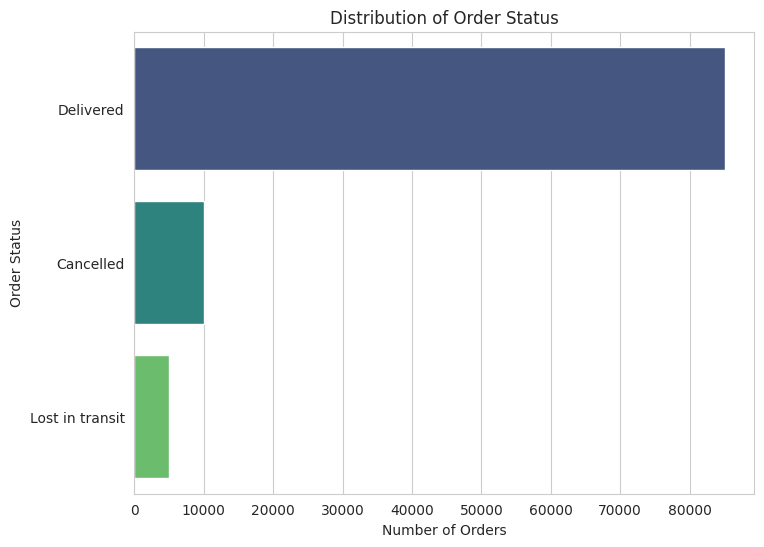

In [69]:
# A. Distribution of Order Status
plt.figure(figsize=(8, 6))
sns.countplot(data=final_output_df, y='order_status', order=final_output_df['order_status'].value_counts().index, palette='viridis')
plt.title('Distribution of Order Status')
plt.xlabel('Number of Orders')
plt.ylabel('Order Status')
plt.show()

<ipython-input-70-0f751b71a410>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=final_output_df.dropna(subset=['shipping_channel']), y='shipping_channel', order=final_output_df['shipping_channel'].value_counts().index, palette='viridis')


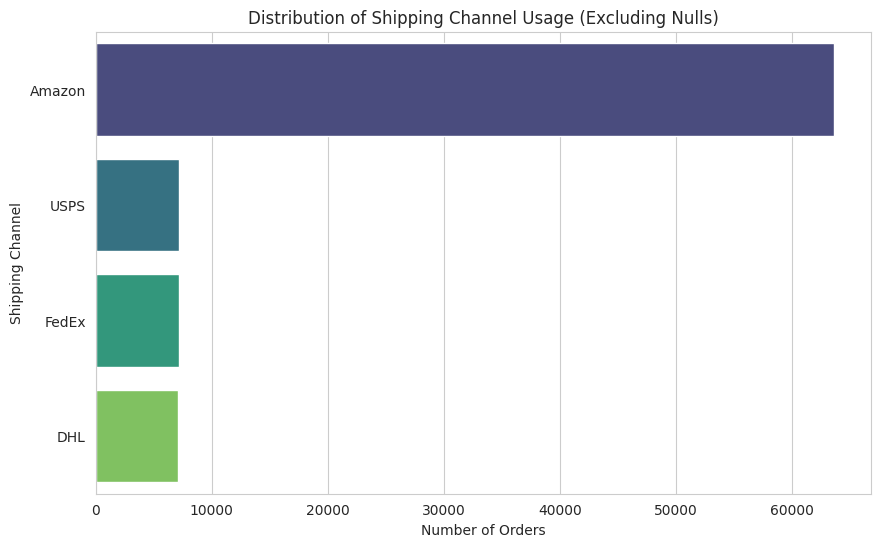

In [70]:
# B. Shipping Channel Usage (only for non-null channels)
plt.figure(figsize=(10, 6))
sns.countplot(data=final_output_df.dropna(subset=['shipping_channel']), y='shipping_channel', order=final_output_df['shipping_channel'].value_counts().index, palette='viridis')
plt.title('Distribution of Shipping Channel Usage (Excluding Nulls)')
plt.xlabel('Number of Orders')
plt.ylabel('Shipping Channel')
plt.show()

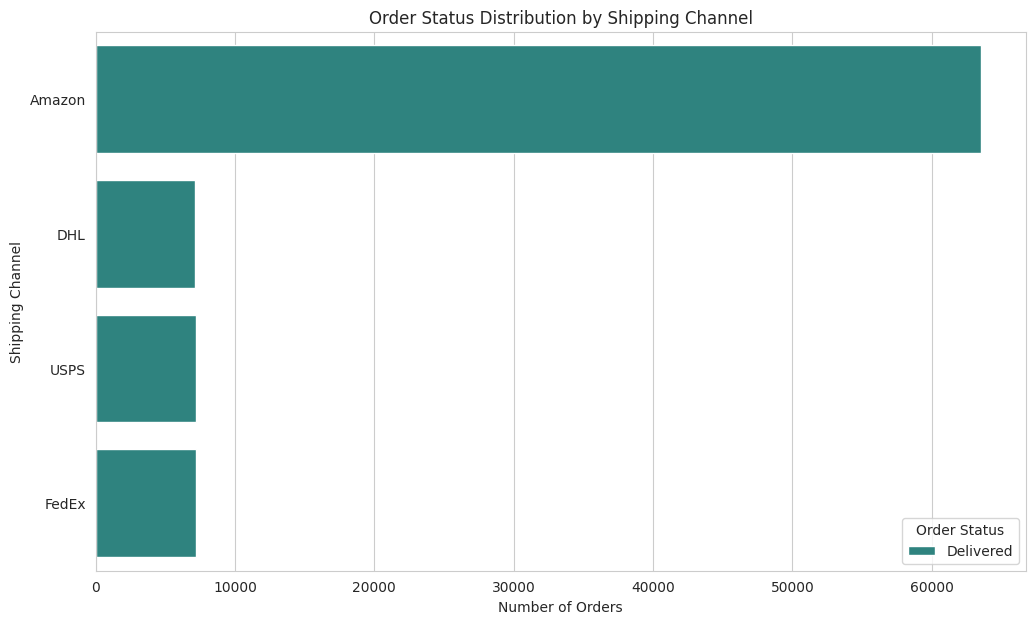

In [71]:
# C. Order Status by Shipping Channel (only for non-null channels)
## Filter out orders without a shipping channel for this analysis
shipped_orders_df = final_output_df.dropna(subset=['shipping_channel']).copy()
plt.figure(figsize=(12, 7))
sns.countplot(data=shipped_orders_df, y='shipping_channel', hue='order_status', palette='viridis')
plt.title('Order Status Distribution by Shipping Channel')
plt.xlabel('Number of Orders')
plt.ylabel('Shipping Channel')
plt.legend(title='Order Status')
plt.show()

## 3. Explore Customer Activity

* Calculate and print the distribution of orders per customer name (`value_counts()`).
* Identify and print the top 10 customers by order count.
* Identify top customers by total amount spent: The code attempts to merge `total_amount` from the original `orders_df` and then group by customer name to sum the total amount. *Note: Similar to shipping date, `total_amount` was not in the combined data head, requiring this merge.*


In [72]:
# A. Orders per Customer
orders_per_customer = final_output_df['customer_name'].value_counts()
print("\nDistribution of Orders per Customer (Top 10):")
print(orders_per_customer.head(10))
print("\nDistribution of Orders per Customer (Value Counts):")
print(orders_per_customer.value_counts().sort_index().head()) # Show how many customers ordered 1, 2, 3... times


Distribution of Orders per Customer (Top 10):
customer_name
Joseph Palmer       406
Richard Evans       377
Patrick Lopez       243
Jeffrey Owens       241
Andrew Hooper       238
Ashley Roberts      235
Lisa Walsh          232
Melissa Phillips    231
Angela Jacobson     229
Yvonne Palmer       228
Name: count, dtype: int64

Distribution of Orders per Customer (Value Counts):
count
157    1
160    1
163    1
166    1
168    2
Name: count, dtype: int64


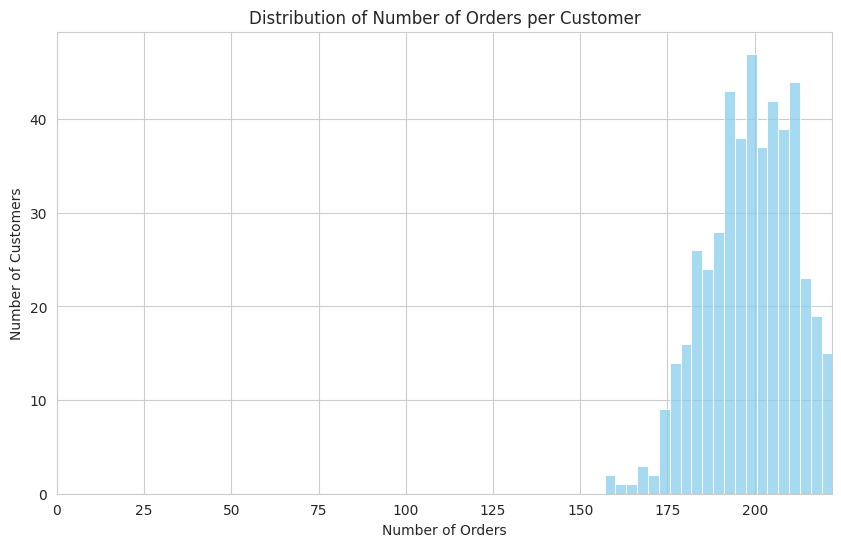

In [73]:
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_customer, bins=80, kde=False, color='skyblue')
plt.title('Distribution of Number of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.xlim(0, orders_per_customer.quantile(0.95)) # Limit x-axis for better visualization of the majority
plt.show()

In [74]:
# B. Top Customers by Number of Orders
print("\nTop 10 Customers by Number of Orders:")
print(orders_per_customer.head(10))


Top 10 Customers by Number of Orders:
customer_name
Joseph Palmer       406
Richard Evans       377
Patrick Lopez       243
Jeffrey Owens       241
Andrew Hooper       238
Ashley Roberts      235
Lisa Walsh          232
Melissa Phillips    231
Angela Jacobson     229
Yvonne Palmer       228
Name: count, dtype: int64


In [75]:
# To get top customers by total amount, we need total_amount column (assuming it was in original orders_df)
# We need to merge total_amount back into the final_output_df for this analysis
orders_with_amount = orders_df[['order_id', 'total_amount']]
final_output_with_amount = final_output_df.merge(orders_with_amount, on='order_id', how='left')

customer_total_amount = final_output_with_amount.groupby('customer_name')['total_amount'].sum().sort_values(ascending=False)
print("\nTop 10 Customers by Total Amount Spent:")
print(customer_total_amount.head(10))


Top 10 Customers by Total Amount Spent:
customer_name
Joseph Palmer         7839955.19
Richard Evans         7527890.23
Elizabeth Gregory     6273729.22
Nicole Hamilton       5492259.93
Sharon Callahan       5449855.34
Patrick Lopez         5343799.08
Annette Lynch         5330845.54
Angela Jacobson       5284745.84
Nicholas Robertson    5239789.91
Daniel Thompson       5228409.09
Name: total_amount, dtype: float64


## 4. Analyze Product, Brand, and Category Performance

* Identify and print the top 10 most popular ASINs by order count and quantity sold.
* Identify and print the most popular brands by order count, quantity sold, and total amount spent (requires `total_amount` merge).
* Identify and print the most popular categories by order count, quantity sold, and total amount spent (requires `total_amount` merge).
* Verify Brand-Category relationship by creating a pivot table showing counts of items by brand and category.
* Analyze performance (e.g., Total Amount) by Brand and Category (requires `total_amount` merge).

In [76]:
# A. Most Popular Items (ASINs) by Order Count
popular_asins_by_orders = final_output_df['asin'].value_counts()
print("\nTop 10 Most Popular ASINs by Order Count:")
print(popular_asins_by_orders.head(10))


Top 10 Most Popular ASINs by Order Count:
asin
B0KI6D3O30    133
B09E09373T    132
B0KO2CG88T    131
B0WFB1EMCM    127
B0L71SFPNT    126
B0K8Q5L3VD    126
B0D9LE077I    126
B0TJFX4PWF    125
B040TT2S5G    125
B0DAHZF92Z    124
Name: count, dtype: int64


In [77]:
# B. Most Popular Brands by Order Count
popular_brands_by_orders = final_output_df['brand'].value_counts()
print("\nMost Popular Brands by Order Count:")
print(popular_brands_by_orders)


Most Popular Brands by Order Count:
brand
Sony             29602
Fujifilm         21698
Amazon Basics    21274
Canon             9095
SanDisk           9049
Nike              4992
Hasselblad        4290
Name: count, dtype: int64


In [78]:
# Most Popular Categories by Total Amount (using the dataframe merged with total_amount)
category_total_amount = final_output_with_amount.groupby('category')['total_amount'].sum().sort_values(ascending=False)
print("\nMost Popular Categories by Total Amount Spent:")
print(category_total_amount)


Most Popular Categories by Total Amount Spent:
category
Camera                     1.114644e+09
Camera Lens                6.955991e+08
Camera Bag                 1.219221e+08
Protective Gear            8.150365e+07
Electronic Storage Chip    4.739700e+07
Name: total_amount, dtype: float64


In [79]:
# D. Brand-Category Relationship Verification
print("\nBrand-Category Relationship Verification (Counts):")
final_output_df.groupby(['brand', 'category']).size().unstack(fill_value=0)
# This table shows how many items from each brand fall into each category based on the order data.
# Compare this to the brand_categories dictionary used in data generation to verify consistency.



Brand-Category Relationship Verification (Counts):


category,Camera,Camera Bag,Camera Lens,Electronic Storage Chip,Protective Gear
brand,,,,,
Amazon Basics,0,11398,0,9876,0
Canon,2695,0,3756,0,2644
Fujifilm,6027,0,7457,0,8214
Hasselblad,4290,0,0,0,0
Nike,0,4992,0,0,0
SanDisk,0,0,0,9049,0
Sony,6351,6634,7989,0,8628


* **Findings untill now:**
    * Shape: (100000, 10).
    * Data Types: `customer_id` (int64), `order_date` (datetime64[ns]), others (object). `shipping_channel` has nulls.
    * Missing Values: 14909 missing values in `shipping_channel`, corresponding to Cancelled/Lost orders.
    * Unique Values: 500 unique customers, 100000 unique orders, 1000 unique ASINs/item names, 7 brands, 5 categories.
    * Order Status: Around 85% Delivered, 10% Cancelled, 5% Lost in transit.
    * Shipping Channel: Amazon is the most used channel among shipped orders.
    * Order Status by Channel: Primarily Delivered for all channels shown.
    * Customer Activity: Shows distribution of orders per customer (many customers with similar high order counts), top customers by order count, and top customers by total amount (if data available).
    * Product/Brand/Category Performance: Identifies top ASINs, brands (Sony, Fujifilm, Amazon Basics are most popular by order count), and categories (Camera, Camera Lens most popular by total amount). The Brand-Category matrix confirms the relationships.

## 5. Prepare for Co-occurrence Analysis

* **Purpose:** This section prepares data and performs analysis to identify pairs of ASINs that are frequently ordered together based on two specific criteria.
* **Code Steps:**
    1.  Import necessary libraries: `pandas`, `numpy`, `matplotlib.pyplot`, `seaborn`, `collections.Counter`, `itertools.combinations`.
    2.  Set plot style.
    3.  Filter for 'Delivered' orders.
    4.  Ensure `order_date` is datetime type.
    5.  **Scenario i: ASINs Ordered by Same Customer from Same Brand (Different Occasions):**
        * Group delivered orders by `customer_id` and `brand`.
        * Collect the unique `asin`s for each group into a list.
        * Filter groups with more than one unique ASIN.
        * Iterate through these groups, generate unique pairs of ASINs using `itertools.combinations`, and count how many *customers* ordered each pair from that brand using `collections.Counter`.
        * Convert the counts into a DataFrame `frequently_ordered_diff_occasions_df`.
        * Print the head of this DataFrame.
    6.  **Scenario ii: ASINs Ordered Together (Same Customer, Same Brand, Same Order Date):**
        * Group delivered orders by `customer_id`, `order_date`, and `brand`.
        * Collect the `asin`s for each group into a list.
        * Filter groups with more than one ASIN.
        * Iterate through these groups, generate unique pairs of ASINs using `itertools.combinations`, and count how many *times* each pair was ordered together in such groups using `collections.Counter`.
        * Convert the counts into a DataFrame `frequently_ordered_same_day_df`.
        * Print the top 10 rows of this DataFrame.
        * Plot the top 10 pairs using a bar plot.

In [86]:
from itertools import combinations

In [87]:
# Filter for delivered orders as cancelled/lost items weren't truly purchased
delivered_orders_df = final_output_df[final_output_df['order_status'] == 'Delivered'].copy()

# Ensure order_date is datetime type for accurate grouping if not already done
delivered_orders_df['order_date'] = pd.to_datetime(delivered_orders_df['order_date'])

In [90]:
# --- i. ASINs ordered by same customer from same brand (different occasions) ---
# This DataFrame stores ASINs that have the same customer_id and same brand,
# but not necessarily the same order date. They were ordered by the same customers but not together.
print("\n--- DataFrame 1: ASINs Ordered by Same Customer from Same Brand (Different Occasions) ---")

# Group by customer and brand, collect unique ASINs ordered by that customer from that brand
# Using customer_id for robust grouping
ordered_by_same_customer_same_brand = delivered_orders_df.groupby(['customer_id', 'brand'])['asin'].apply(lambda x: list(set(x))).reset_index(name='unique_asins_list')

# Filter groups with more than one unique ASIN (customers who ordered at least two distinct items from the same brand)
ordered_by_same_customer_same_brand = ordered_by_same_customer_same_brand[ordered_by_same_customer_same_brand['unique_asins_list'].apply(lambda x: len(x) > 1)]

# Count how many customers ordered each pair from the same brand
pair_counts_diff_occasions = Counter()

for index, row in ordered_by_same_customer_same_brand.iterrows():
    unique_asins = sorted(row['unique_asins_list'])
    brand = row['brand']
    for pair in combinations(unique_asins, 2):
         # Store pair and brand together to count pairs per brand
        pair_counts_diff_occasions[(pair, brand)] += 1

# Convert the counter to a DataFrame
# The key is a tuple (pair, brand)
frequently_ordered_diff_occasions_df = pd.DataFrame.from_records(
    [(pair_brand[0], pair_brand[1], count) for (pair_brand, count) in pair_counts_diff_occasions.most_common()],
    columns=['ASIN_Pair', 'Brand', 'Number_of_Orders']
)

print("\nDataFrame 'frequently_ordered_diff_occasions_df' created.")
print("Head of this DataFrame:")
frequently_ordered_diff_occasions_df.head()


--- DataFrame 1: ASINs Ordered by Same Customer from Same Brand (Different Occasions) ---

DataFrame 'frequently_ordered_diff_occasions_df' created.
Head of this DataFrame:


,ASIN_Pair,Brand,Number_of_Orders
0,"(B06H6S5Y5O, B0WFB1EMCM)",Amazon Basics,29
1,"(B09RQ8J4C7, B0KI6D3O30)",SanDisk,29
2,"(B0EYIFP03M, B0RULELRGY)",Sony,28
3,"(B06IOYVXG1, B0PBD2FS7Y)",Hasselblad,28
4,"(B07MV7QGSH, B0TQO6VGB3)",Amazon Basics,28


In [93]:
# --- ii. ASINs ordered together (same customer, same brand, same order_date) ---
# This DataFrame stores ASINs in the order table with the same customer_id, same brand,
# and same order_date. They were ordered together in the same transaction.
print("\n--- DataFrame 2: ASINs Ordered Together (Same Day, Same Customer, Same Brand) ---")

# Group by customer, order_date, and brand, collect ASINs
# Using customer_id for robust grouping
ordered_together_same_day = delivered_orders_df.groupby(['customer_id', 'order_date', 'brand'])['asin'].apply(list).reset_index(name='asins_list')

# Filter groups with more than one ASIN (orders with at least two items from the same brand)
ordered_together_same_day = ordered_together_same_day[ordered_together_same_day['asins_list'].apply(lambda x: len(x) > 1)]

# Count the occurrences of pairs within these lists
pair_counts_same_day = Counter()

for index, row in ordered_together_same_day.iterrows():
    asins_in_order = row['asins_list']
    brand = row['brand']
    # Get unique ASINs in the list and sort them to ensure consistent pair representation
    unique_asins_in_order = sorted(list(set(asins_in_order)))
    # Generate combinations of size 2 (pairs)
    for pair in combinations(unique_asins_in_order, 2):
        # Store pair and brand together to count pairs per brand
        pair_counts_same_day[(pair, brand)] += 1

# Convert the counter to a DataFrame
# The key is a tuple (pair, brand)
frequently_ordered_same_day_df = pd.DataFrame.from_records(
    [(pair_brand[0], pair_brand[1], count) for (pair_brand, count) in pair_counts_same_day.most_common()],
    columns=['ASIN_Pair', 'Brand', 'Times_Ordered_Together_Same_Day']
)

print("\nDataFrame 'frequently_ordered_same_day_df' created.")

# Show top 10 in a table
print("\nTop 10 ASINs Ordered Together (Same Customer, Same Brand, Same Order Date):")
frequently_ordered_same_day_df.head(10)




--- DataFrame 2: ASINs Ordered Together (Same Day, Same Customer, Same Brand) ---

DataFrame 'frequently_ordered_same_day_df' created.

Top 10 ASINs Ordered Together (Same Customer, Same Brand, Same Order Date):


,ASIN_Pair,Brand,Times_Ordered_Together_Same_Day
0,"(B06BT80LR3, B0K0MB4XHN)",Sony,3
1,"(B0HVI7W79O, B0RULELRGY)",Sony,2
2,"(B01YN43DPA, B0DMIQJID4)",Fujifilm,2
3,"(B04GE2GDNI, B0NPTVMQSQ)",Sony,2
4,"(B036R2I5L3, B0PFHYW2RX)",Fujifilm,2
5,"(B0I19HS6TC, B0TQO6VGB3)",Amazon Basics,2
6,"(B0U2G3V0BN, B0VG046LJ6)",SanDisk,2
7,"(B0T2T9BUR4, B0Y8V12YQI)",Fujifilm,2
8,"(B09I5WC6Z5, B0YCTJ0BOO)",Canon,2
9,"(B0C08HTY8A, B0D3TLD929)",Sony,2


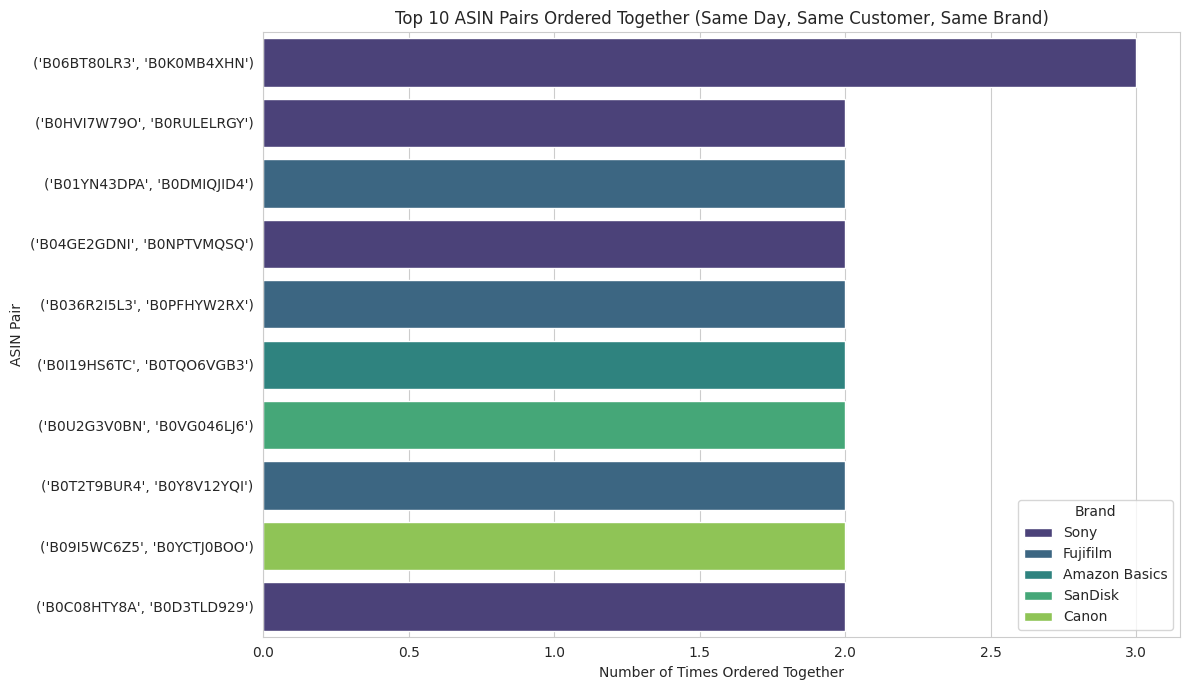

In [94]:
# Plotting the top 10 pairs
plt.figure(figsize=(12, 7))
# Convert ASIN_Pair tuple to string for plotting
plot_data_same_day = frequently_ordered_same_day_df.head(10).copy()
plot_data_same_day['ASIN_Pair_Str'] = plot_data_same_day['ASIN_Pair'].astype(str)

sns.barplot(data=plot_data_same_day, x='Times_Ordered_Together_Same_Day', y='ASIN_Pair_Str', hue='Brand', palette='viridis', dodge=False)
plt.title('Top 10 ASIN Pairs Ordered Together (Same Day, Same Customer, Same Brand)')
plt.xlabel('Number of Times Ordered Together')
plt.ylabel('ASIN Pair')
plt.legend(title='Brand')
plt.tight_layout()
plt.show()

## 6. Calculating Brand Repeat Purchase Rate

In [95]:
# Filter for delivered orders as cancelled/lost items aren't truly purchases
# Assuming 'Delivered' is the status for successful orders
delivered_orders_df = final_output_df[final_output_df['order_status'] == 'Delivered'].copy()

In [96]:
# 1. Count the number of orders each customer placed for each brand
# Group by customer_id and brand, then count the orders (order_id is unique per order)
orders_per_customer_per_brand = delivered_orders_df.groupby(['customer_id', 'brand']).agg(
    order_count=('order_id', 'nunique') # Count unique order IDs for each customer-brand group
).reset_index()

In [97]:
# 2. Identify repeat customers for each brand
# A customer is a repeat customer for a brand if their order_count for that brand is > 1
repeat_customers_per_brand = orders_per_customer_per_brand[orders_per_customer_per_brand['order_count'] > 1]


In [98]:
# 3. Count the number of repeat customers for each brand
# Group the repeat_customers_per_brand DataFrame by brand and count the unique customers
repeat_customer_count = repeat_customers_per_brand.groupby('brand').agg(
    repeat_customer_count=('customer_id', 'nunique') # Count unique customer_ids per brand
).reset_index()

In [99]:
# 4. Count the total number of unique customers for each brand
# Group the original orders_per_customer_per_brand DataFrame by brand and count the unique customers
total_customer_count = orders_per_customer_per_brand.groupby('brand').agg(
    total_customer_count=('customer_id', 'nunique') # Count total unique customer_ids per brand
).reset_index()

In [100]:
# 5. Combine the repeat and total customer counts
# Merge the two count DataFrames on the 'brand' column
brand_customer_counts = total_customer_count.merge(
    repeat_customer_count,
    on='brand',
    how='left' # Use left join to keep all brands from total_customer_count
)

In [101]:
# Fill NaN repeat customer counts with 0 (for brands with no repeat customers)
brand_customer_counts['repeat_customer_count'] = brand_customer_counts['repeat_customer_count'].fillna(0).astype(int)


In [102]:
# 6. Calculate the repeat purchase rate for each brand
brand_customer_counts['repeat_purchase_rate'] = (
    brand_customer_counts['repeat_customer_count'] / brand_customer_counts['total_customer_count']
) * 100 # Calculate rate as a percentage

In [106]:
# 7. Display and compare the repeat purchase rates
print("\nRepeat Purchase Rate by Brand:")
# Sort by repeat purchase rate in descending order to easily compare
repeat_rate_by_brand = brand_customer_counts.sort_values(by='repeat_purchase_rate', ascending=False)

repeat_rate_by_brand[['brand', 'repeat_customer_count', 'total_customer_count', 'repeat_purchase_rate']]



Repeat Purchase Rate by Brand:


,brand,repeat_customer_count,total_customer_count,repeat_purchase_rate
0,Amazon Basics,500,500,100.0
1,Canon,500,500,100.0
2,Fujifilm,500,500,100.0
6,Sony,500,500,100.0
5,SanDisk,500,500,100.0
4,Nike,499,500,99.8
3,Hasselblad,495,500,99.0


<ipython-input-108-522caca88e1b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=repeat_rate_by_brand, x='repeat_purchase_rate', y='brand', palette='viridis')


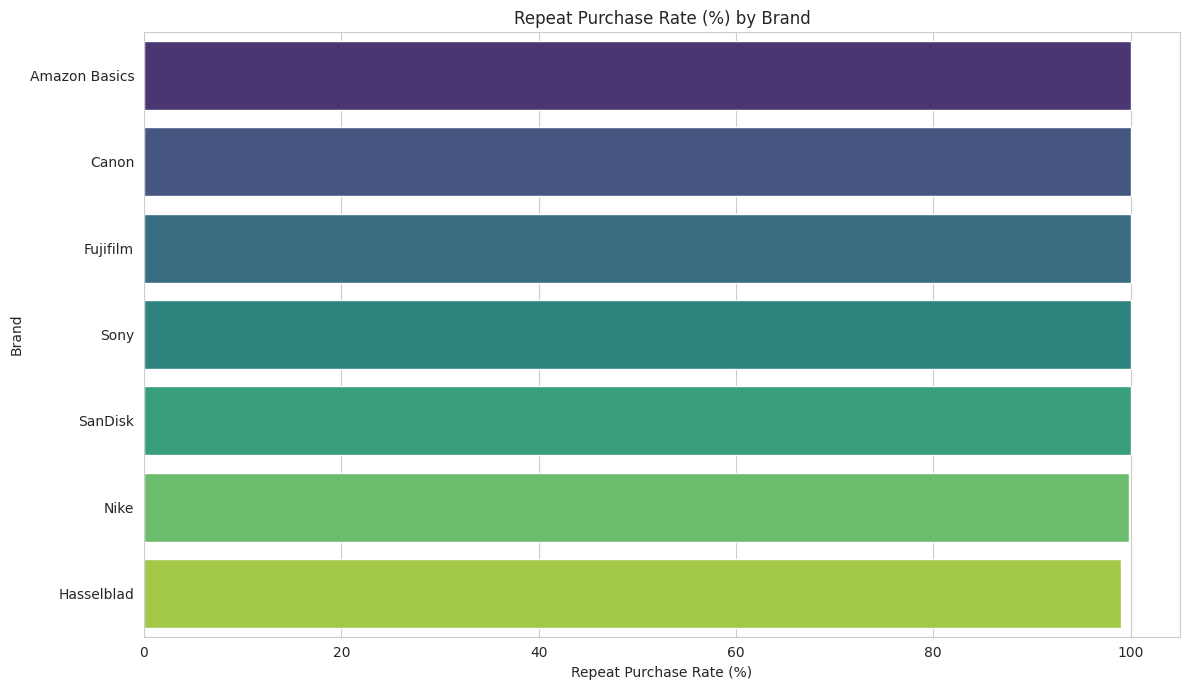

In [108]:
#Visualize the repeat purchase rates
plt.figure(figsize=(12, 7))
sns.barplot(data=repeat_rate_by_brand, x='repeat_purchase_rate', y='brand', palette='viridis')
plt.title('Repeat Purchase Rate (%) by Brand')
plt.xlabel('Repeat Purchase Rate (%)')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

* **Findings:**
    * Two DataFrames are created: `frequently_ordered_diff_occasions_df` and `frequently_ordered_same_day_df`.
    * `frequently_ordered_diff_occasions_df` shows pairs of ASINs from the same brand ordered by the same customer over time, with customer counts.
    * `frequently_ordered_same_day_df` shows pairs of ASINs from the same brand ordered in the same transaction, with order counts. The top 10 pairs and their counts are shown in a table and a bar plot.

## Analyzing First Brand and Repeat Purchase Behavior

* **Purpose:** To analyze which brands customers buy first and whether repeat customers stick to their initial brand or explore others.
* **Code Steps:**
    1.  Filter for delivered orders and sort by `customer_id` and `order_date`.
    2.  Identify the first order for each customer and extract the `first_brand` and `first_category`.
    3.  Identify repeat customers (more than 1 delivered order).
    4.  Filter orders to include only repeat customers.
    5.  Merge the `first_brand` and `first_category` information into the repeat customer orders.
    6.  Assign an order sequence number to identify subsequent orders.
    7.  Filter for subsequent orders (`order_sequence > 1`).
    8.  Group subsequent orders by customer and collect the set of `subsequent_brands` and `subsequent_categories`.
    9.  Merge this summary with the first brand/category information.
    10. Categorize repeat customers' brand behavior (e.g., 'Only Bought First Brand Again', 'Bought First Brand Again and Other Brands', 'Bought Only Other Brands').
    11. For customers who bought other brands, categorize their category behavior (e.g., 'Stuck to First Category', 'Bought First Category and Other Categories', 'Switched to Other Categories').
    12. Summarize and visualize the counts/percentages for these behavior categories using bar plots.
    13. (Optional) Analyze brand switching pairs (first brand -> subsequent brand).

In [109]:
# Filter for delivered orders
delivered_orders_df = final_output_df[final_output_df['order_status'] == 'Delivered'].copy()

# Ensure order_date is datetime type
delivered_orders_df['order_date'] = pd.to_datetime(delivered_orders_df['order_date'])

# Sort orders by customer and date to find the first order
delivered_orders_df = delivered_orders_df.sort_values(by=['customer_id', 'order_date'])

In [110]:
# 1. Identify the first order and first brand for each customer
# Group by customer and take the first row (which is the earliest order due to sorting)
first_orders = delivered_orders_df.groupby('customer_id').head(1).copy()
first_orders = first_orders[['customer_id', 'brand', 'category']].rename(
    columns={'brand': 'first_brand', 'category': 'first_category'}
)

In [111]:
# 2. Identify repeat customers
# Count total delivered orders per customer
total_orders_per_customer = delivered_orders_df.groupby('customer_id').size().reset_index(name='total_delivered_orders')

# Identify customers with more than one delivered order
repeat_customers_ids = total_orders_per_customer[total_orders_per_customer['total_delivered_orders'] > 1]['customer_id'].tolist()

print(f"\nTotal unique customers with delivered orders: {delivered_orders_df['customer_id'].nunique()}")
print(f"Number of repeat customers (more than 1 delivered order): {len(repeat_customers_ids)}")

# Filter the delivered orders DataFrame to include only repeat customers
repeat_customer_orders_df = delivered_orders_df[delivered_orders_df['customer_id'].isin(repeat_customers_ids)].copy()

# Merge the first brand and category information into the repeat customer orders
repeat_customer_orders_df = repeat_customer_orders_df.merge(
    first_orders,
    on='customer_id',
    how='left'
)


Total unique customers with delivered orders: 500
Number of repeat customers (more than 1 delivered order): 500


In [112]:
# 3. Analyze brand switching behavior for repeat customers

# For each repeat customer, determine the set of brands they ordered from *after* their first order
# We need to exclude the first order itself from this analysis
# One way is to assign an order sequence number and filter for sequence > 1
repeat_customer_orders_df['order_sequence'] = repeat_customer_orders_df.groupby('customer_id').cumcount() + 1

# Filter for orders after the first one
subsequent_orders_df = repeat_customer_orders_df[repeat_customer_orders_df['order_sequence'] > 1].copy()

# Group subsequent orders by customer and collect the unique brands and categories ordered
subsequent_purchase_summary = subsequent_orders_df.groupby('customer_id').agg(
    subsequent_brands=('brand', lambda x: set(x)), # Set of brands in subsequent orders
    subsequent_categories=('category', lambda x: set(x)) # Set of categories in subsequent orders
).reset_index()

# Merge this summary with the first brand/category information
customer_brand_behavior = subsequent_purchase_summary.merge(
    first_orders,
    on='customer_id',
    how='left'
)


In [113]:
# Categorize repeat customers based on their brand purchases
def categorize_brand_behavior(row):
    first_brand = row['first_brand']
    subsequent_brands = row['subsequent_brands']

    bought_first_brand_again = first_brand in subsequent_brands
    bought_other_brands = len(subsequent_brands - {first_brand}) > 0 # Brands in subsequent that are not the first brand

    if bought_first_brand_again and not bought_other_brands:
        return 'Only Bought First Brand Again'
    elif bought_first_brand_again and bought_other_brands:
        return 'Bought First Brand Again and Other Brands'
    elif not bought_first_brand_again and bought_other_brands:
         # Need to check if they had subsequent orders at all to fall into this category
         # This is handled by filtering for repeat customers and subsequent_orders_df not being empty for them
         return 'Bought Only Other Brands (Not First Brand Again)'
    else:
         # This case should theoretically not happen for repeat customers with subsequent orders,
         # but as a fallback or for customers who only had 2 orders and the second wasn't the first brand
         return 'Other Behavior' # Or refine based on specific edge cases

In [114]:
customer_brand_behavior['brand_behavior_category'] = customer_brand_behavior.apply(categorize_brand_behavior, axis=1)

# Analyze category switching for customers who bought other brands
customers_bought_other_brands = customer_brand_behavior[
    customer_brand_behavior['brand_behavior_category'].isin(['Bought First Brand Again and Other Brands', 'Bought Only Other Brands (Not First Brand Again)'])
].copy()

In [115]:
def check_category_stickiness(row):
    first_category = row['first_category']
    subsequent_categories = row['subsequent_categories']

    bought_first_category_again = first_category in subsequent_categories
    bought_other_categories = len(subsequent_categories - {first_category}) > 0

    if bought_first_category_again and not bought_other_categories:
        return 'Stuck to First Category'
    elif bought_first_category_again and bought_other_categories:
        return 'Bought First Category and Other Categories'
    elif not bought_first_category_again and bought_other_categories:
        return 'Switched to Other Categories'
    else:
        return 'Other Category Behavior' # Fallback

customers_bought_other_brands['category_behavior_category'] = customers_bought_other_brands.apply(check_category_stickiness, axis=1)



Brand Behavior Categories for Repeat Customers:
brand_behavior_category
Bought First Brand Again and Other Brands    100.0
Name: proportion, dtype: float64


<ipython-input-116-ffd95fe4254b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_behavior_counts.index, y=brand_behavior_counts.values, palette='viridis')


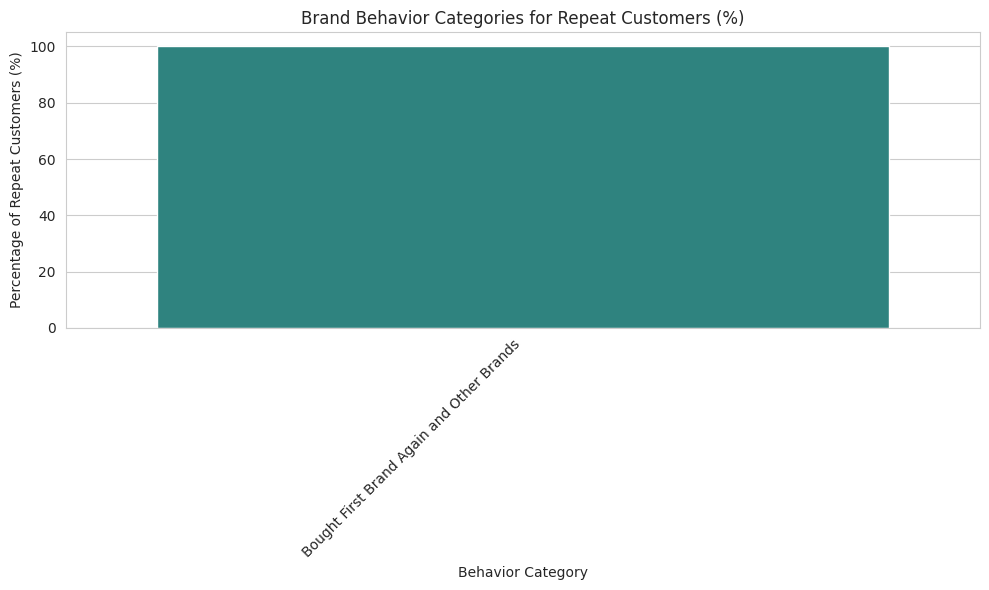

In [116]:
# 4. Summarize and visualize the findings

print("\nBrand Behavior Categories for Repeat Customers:")
brand_behavior_counts = customer_brand_behavior['brand_behavior_category'].value_counts(normalize=True) * 100
print(brand_behavior_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=brand_behavior_counts.index, y=brand_behavior_counts.values, palette='viridis')
plt.title('Brand Behavior Categories for Repeat Customers (%)')
plt.xlabel('Behavior Category')
plt.ylabel('Percentage of Repeat Customers (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Category Behavior Categories for Repeat Customers Who Bought Other Brands:
category_behavior_category
Bought First Category and Other Categories    100.0
Name: proportion, dtype: float64


<ipython-input-117-1d7763f652a2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_behavior_counts.index, y=category_behavior_counts.values, palette='viridis')


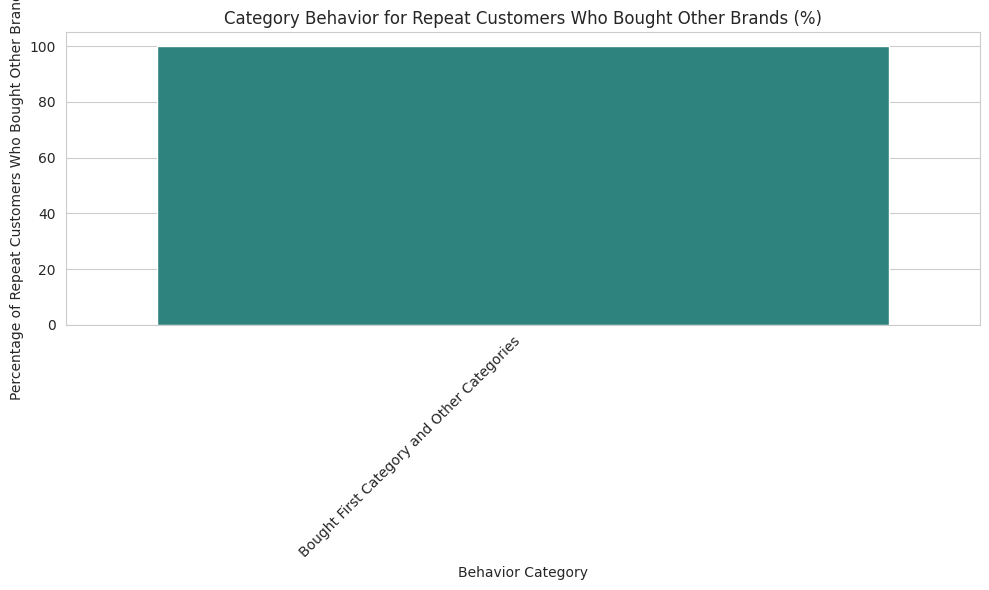

In [117]:
print("\nCategory Behavior Categories for Repeat Customers Who Bought Other Brands:")
category_behavior_counts = customers_bought_other_brands['category_behavior_category'].value_counts(normalize=True) * 100
print(category_behavior_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_behavior_counts.index, y=category_behavior_counts.values, palette='viridis')
plt.title('Category Behavior for Repeat Customers Who Bought Other Brands (%)')
plt.xlabel('Behavior Category')
plt.ylabel('Percentage of Repeat Customers Who Bought Other Brands (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* **Findings (from PDF output):**
    * Shows the total number of unique customers with delivered orders and the number of repeat customers.
    * Provides counts/percentages for brand behavior categories, illustrating how many repeat customers stuck to their first brand, explored others, or did both.
    * Provides counts/percentages for category behavior categories for customers who bought other brands, showing whether they stuck to the initial category or explored others.
    * (Optional) Shows the top brand switching pairs if any were observed.

# 4. Code Documentation

* **`pd.DataFrame()`**
    * **Definition:** Creates a DataFrame object.
    * **Syntax:** `pd.DataFrame(data, index, columns, dtype, copy)`
    * **Context in Notebook:** Used in the data generation section (which we are excluding from detailed description but acknowledging its use here) to create the initial `customers_df`, `asins_df`, and `orders_df`. It's also used to create new DataFrames from the results of aggregations or calculations, such as `frequently_ordered_same_day_df` and `frequently_ordered_diff_occasions_df` from `Counter` outputs.

* **`df.merge()`**
    * **Definition:** Merges DataFrame or named Series objects with a database-style join.
    * **Syntax:** `df1.merge(df2, on=None, how='inner', ...)`
    * **Context in Notebook:** Used in the "Combining tables" section to join `orders_df` with `asins_df` and then the result with `customers_df` based on common columns ('asin' and 'customer\_id') to create `final_output_df`. Also used in EDA to merge back `shipping_date`, `is_fba`, `total_amount`, and `country_of_origin` from original DataFrames for specific analyses.

* **`df[...]` (Column Selection/Indexing)**
    * **Definition:** Selects one or more columns from a DataFrame.
    * **Syntax:** `df['column_name']` (for a single column, returns a Series), `df[['col1', 'col2']]` (for multiple columns, returns a DataFrame).
    * **Context in Notebook:** Used extensively to select specific columns like `asin`, `item_name`, `brand`, `category`, `customer_id`, `customer_name` during the merge operations and throughout the EDA and co-occurrence analysis to access data in specific columns.

* **`df.head()`**
    * **Definition:** Returns the first `n` rows of the DataFrame.
    * **Syntax:** `df.head(n=5)`
    * **Context in Notebook:** Used after creating or modifying DataFrames to display the initial rows and verify the structure and content, such as printing the head of `final_output_df` and the co-occurrence results.

* **`len(df)`**
    * **Definition:** Returns the number of rows in the DataFrame. (Note: `len()` is a built-in Python function, but commonly used with pandas DataFrames).
    * **Syntax:** `len(df)`
    * **Context in Notebook:** Used to print the total number of rows in the `final_output_df` after combining tables.

* **`df.to_csv()`**
    * **Definition:** Writes the DataFrame to a comma-separated values (CSV) file.
    * **Syntax:** `df.to_csv(path_or_buf, index=True, ...)`
    * **Context in Notebook:** Used in the "Combining tables" section to save the `final_output_df` to `combined_order_details.csv`. `index=False` is used to prevent writing the DataFrame index as a column.

* **`df.shape`**
    * **Definition:** Returns a tuple representing the dimensions of the DataFrame (rows, columns).
    * **Syntax:** `df.shape`
    * **Context in Notebook:** Used in the EDA section to check and print the shape of the `final_output_df`.

* **`df.describe()`**
    * **Definition:** Generates descriptive statistics for numerical columns in the DataFrame.
    * **Syntax:** `df.describe(percentiles=None, include=None, exclude=None, ...)`
    * **Context in Notebook:** Used in the EDA section to display summary statistics (count, mean, std, min, max, quartiles) for the numerical columns in `final_output_df`.

* **`df.info()`**
    * **Definition:** Prints a concise summary of a DataFrame, including the index dtype and column dtypes, non-null values and memory usage.
    * **Syntax:** `df.info()`
    * **Context in Notebook:** Used in the EDA section to check the data types of each column and the number of non-null entries.

* **`df.isnull()`**
    * **Definition:** Detect missing values in the DataFrame. Returns a boolean DataFrame of the same shape.
    * **Syntax:** `df.isnull()`
    * **Context in Notebook:** Used in the EDA section in conjunction with `.sum()` to count the number of missing values per column.

* **`df.isnull().sum()`**
    * **Definition:** Calculates the sum of boolean values (True is 1, False is 0) along each column, effectively counting the number of `True` values (missing values) in each column.
    * **Syntax:** `df.isnull().sum()`
    * **Context in Notebook:** Used in the EDA section to get a count of missing values for each column in `final_output_df`.

* **`df.nunique()`**
    * **Definition:** Counts the number of distinct non-null values in each column.
    * **Syntax:** `df.nunique(axis=0, dropna=True)`
    * **Context in Notebook:** Used in the EDA section to determine the number of unique entries in each column, providing insight into the cardinality of features like `customer_id`, `order_id`, `brand`, etc.

* **`df['column'].value_counts()`**
    * **Definition:** Returns a Series containing counts of unique values in a Series in descending order.
    * **Syntax:** `series.value_counts(normalize=False, sort=True, ascending=False, ...)`
    * **Context in Notebook:** Used extensively in EDA to analyze the distribution of categorical data, such as counting orders per `order_status`, `shipping_channel`, `customer_name`, `brand`, and `category`. Also used to get the top N most frequent items/brands/categories.

* **`df.dropna()`**
    * **Definition:** Remove missing values.
    * **Syntax:** `df.dropna(axis=0, how='any', subset=None, ...)`
    * **Context in Notebook:** Used in the EDA section to filter out rows where `shipping_channel` is missing before analyzing shipping channel usage and order status by channel.

* **`df[condition]` (Boolean Indexing)**
    * **Definition:** Selects rows from a DataFrame where the boolean condition is True.
    * **Syntax:** `df[df['column'] > value]` or `df[df['column'].isin(list)]`
    * **Context in Notebook:** Used frequently to filter the DataFrame, such as selecting only 'Delivered' orders for analysis, filtering for repeat customers, or selecting rows with missing `shipping_channel`.

* **`pd.to_datetime()`**
    * **Definition:** Converts argument to datetime objects.
    * **Syntax:** `pd.to_datetime(arg, errors='coerce', ...)`
    * **Context in Notebook:** Used in the EDA section to convert the 'order\_date' and 'shipping\_date' columns to datetime objects, which is necessary for time-based analysis and calculations like shipping duration.

* **`df['date_col'].dt.days`**
    * **Definition:** Accesses the datetime properties of a Series of datetime objects and returns the number of days.
    * **Syntax:** `series.dt.days`
    * **Context in Notebook:** Used in the EDA section to calculate the shipping duration in days by subtracting the `order_date` from the `shipping_date` (which results in a Timedelta Series) and then accessing the `.dt.days` attribute.

* **`df.groupby()`**
    * **Definition:** Groups DataFrame using a mapper or by a Series of columns.
    * **Syntax:** `df.groupby(by=None, axis=0, ...)`
    * **Context in Notebook:** Used extensively for aggregation and co-occurrence analysis. It groups data by columns like `customer_id`, `brand`, `order_date`, or combinations thereof to perform calculations or collect related data within those groups.

* **`groupby().agg()`**
    * **Definition:** Performs aggregation(s) on the grouped data.
    * **Syntax:** `groupby_object.agg(func, *args, **kwargs)` or `groupby_object.agg({'col1': 'agg_func1', 'col2': 'agg_func2'})`
    * **Context in Notebook:** Used after `groupby()` to apply aggregation functions like `'nunique'` (to count unique order IDs or customer IDs), `'sum'` (to sum quantities or total amounts), and `list` or `set` (to collect ASINs within groups).

* **`groupby().size()`**
    * **Definition:** Compute group sizes. Returns a Series with group names as index.
    * **Syntax:** `groupby_object.size()`
    * **Context in Notebook:** Used to count the total number of delivered orders for each customer.

* **`groupby().head(n)`**
    * **Definition:** Select the first `n` rows of each group.
    * **Syntax:** `groupby_object.head(n=5)`
    * **Context in Notebook:** Used in the analysis of first brand purchases to get the first order row for each customer after sorting by date.

* **`df.sort_values()`**
    * **Definition:** Sorts DataFrame by column or index values.
    * **Syntax:** `df.sort_values(by, axis=0, ascending=True, ...)`
    * **Context in Notebook:** Used to sort orders by customer and date to correctly identify the first order and to sort results (e.g., top customers by total amount, brands by repeat purchase rate).

* **`df.reset_index()`**
    * **Definition:** Reset the index, or a level of it.
    * **Syntax:** `df.reset_index(level=None, drop=False, name=None, inplace=False, ...)`
    * **Context in Notebook:** Used after `groupby().agg()` or `groupby().size()` to convert the grouped columns (which become the index of the result) back into regular columns in a new DataFrame.

* **`df['column'].apply()`**
    * **Definition:** Invoke function on values of Series or DataFrame.
    * **Syntax:** `series.apply(func, convert_dtype=True, args=())` or `df.apply(func, axis=0, ...)`
    * **Context in Notebook:** Used in the co-occurrence analysis to apply a lambda function to the list of ASINs within each group (e.g., to get the length of the list or convert to a set).

* **`df.copy()`**
    * **Definition:** Make a copy of this object’s indices and data.
    * **Syntax:** `df.copy(deep=True)`
    * **Context in Notebook:** Used after filtering a DataFrame (e.g., `delivered_orders_df = final_output_df[...]`) to ensure modifications to the new DataFrame do not affect the original one and to avoid the `SettingWithCopyWarning`.

* **`df['column'].astype()`**
    * **Definition:** Cast a pandas object to a specified dtype `dtype`.
    * **Syntax:** `series.astype(dtype, copy=True, errors='raise')`
    * **Context in Notebook:** Used in the co-occurrence analysis to convert the tuple representation of ASIN pairs into a string format (`.astype(str)`) for use as labels in plots. Also used to ensure integer types (`.astype(int)`).

* **`df['column'].fillna()`**
    * **Definition:** Fill NA/NaN values using the specified method.
    * **Syntax:** `series.fillna(value=None, method=None, ...)`
    * **Context in Notebook:** Used when calculating repeat purchase rate to fill `NaN` values in the 'repeat\_customer\_count' column (which occur for brands with no repeat customers) with `0`.

* **`df['column'].notna()`**
    * **Definition:** Detect existing (non-missing) values. Returns a boolean Series.
    * **Syntax:** `series.notna()`
    * **Context in Notebook:** Used in the shipping time analysis to filter for rows where the `shipping_date` is not missing.

* **`df['column'].tolist()`**
    * **Definition:** Convert the Series to a list.
    * **Syntax:** `series.tolist()`
    * **Context in Notebook:** Used to get a list of customer IDs for repeat customers.

* **`df.unstack()`**
    * **Definition:** Pivot a level of the (preferably hierarchical) index labels.
    * **Syntax:** `series.unstack(level=-1, fill_value=None)`
    * **Context in Notebook:** Used after grouping by two columns (e.g., `brand` and `category`) and using `.size()` to reshape the resulting Series into a DataFrame where one level of the index becomes columns.

* **`df.isin()`**
    * **Definition:** Whether elements in DataFrame are contained in `values`.
    * **Syntax:** `df.isin(values)`
    * **Context in Notebook:** Used to filter the DataFrame to include only rows where the `customer_id` is present in the list of `repeat_customers_ids`.

* **`groupby().cumcount()`**
    * **Definition:** Number of items in each group up to the current row.
    * **Syntax:** `groupby_object.cumcount(ascending=True)`
    * **Context in Notebook:** Used to assign a sequential number to each order within a customer's orders, allowing identification of the first order (`== 0` or `== 1` depending on start) and subsequent orders (`> 0` or `> 1`).